## Initialization

In [163]:
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11

In [162]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

In [155]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

In [14]:
import numpy as np
import numba
import pandas as pd
from reactionmodel.model import Species, Reaction, Model

In [15]:
def make_df(results, t_eval):
    result_series = []

    for r in results:
        t, y = r.restricted_values(t_eval)
        result_series.append(pd.Series(y.T.squeeze(), index=t))
    
    df = pd.concat(result_series, axis=1)
    df = df.dropna()
    return df

# ABSORPTION

So as an approximate rule of thumb, the absorption exponential generally becomes negligible and ln(Cp) values fall on a terminal line when t > 7·t½,abs.

https://www.sciencedirect.com/topics/medicine-and-dentistry/absorption-half-life#:~:text=First%2Dorder%20absorption%20occurs%20when,at%20the%20site%20of%20administration.

$$ \lambda(t) = \frac{R_0 \mu}{1 + (1/\text{IC}_{50} e^{- \log(2) t / t_{\text{half}}})^{m_\text{drug}}} $$

First order absorption:

$$r_{\text{abs}} = k_a FD \cdot e^{-k_a t} $$

Concentration as a function of time:

$$ C(t) = FD [ 1 - e^{-k_a t }]

In [16]:
IC50 = 1.0
mdrug = 1.0
FD = 8.0 # size of first dose
t_half_abs = (1/4) # days
ka = np.log(2) / t_half_abs # rate of absorption
R0 = 5.0 # R0 in absence of drug
mu = 1.0 # death rate / day

early_start = False

@numba.jit(nopython=True)
def lambda_t_late_start(t):
    concentration = FD * (1 - np.exp(-1 * ka * t))
    inhibition = (1 + (concentration/(IC50))**(mdrug))
    return R0 * mu / inhibition

@numba.jit(nopython=True)
def lambda_t_early_start(t):
    if t < 1:
        return R0 * mu
    concentration = FD * (1 - np.exp(-1 * ka * (t-1)))
    inhibition = (1 + (concentration/(IC50))**(mdrug))
    return R0 * mu / inhibition

if early_start:
    lambda_t = lambda_t_early_start
else:
    lambda_t = lambda_t_late_start

In [17]:
t_upper = t_half_abs*40

t_eval_late_start = np.linspace(0.0, t_upper, 221)
t_eval_early_start = np.linspace(0.0, t_upper + 1, 221)
t_span_late_start = [0, t_upper]
t_span_early_start = [0, t_upper + 1]

if early_start:
    t_eval = t_eval_early_start
    t_span = t_span_early_start
else:
    t_eval = t_eval_late_start
    t_span = t_span_late_start

R0s = [lambda_t_early_start(t)/mu for t in t_eval_early_start]

Text(0.5, 0, 'time (lifespans of infected cell)')

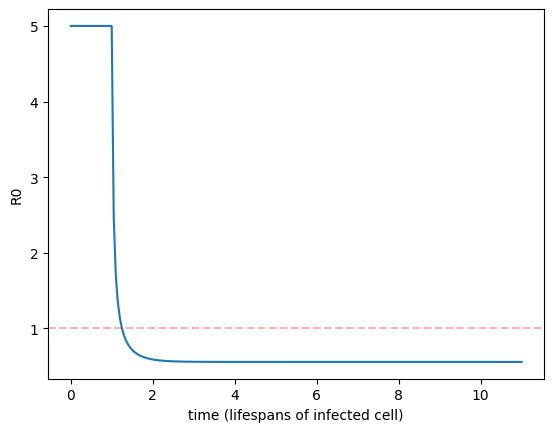

In [18]:
fig, ax = plt.subplots(1)

ax.plot(t_eval_early_start, R0s)
ax.set_ylabel('R0')
plt.axhline(1.0, c='r', linestyle='--', alpha=0.3)
ax.set_xlabel('time (lifespans of infected cell)')

In [19]:
y0_early_start = 200
if early_start:
    y0 = 20
    y0 = 40
    y0 = 200
    discontinuities = [1.0]
else:
    y0 = 500
    y0 = 10000
    discontinuities = []

Y = Species('Y')

death = Reaction([Y], [], k=mu)
birth = Reaction([Y], [(Y, 2)], k=lambda_t)

m = Model([Y], [birth, death])
m_early_start = Model([Y], [Reaction([Y], [(Y, 2)], k=lambda_t_early_start), death])

In [7]:
epsilon = 0.01

## Deterministic

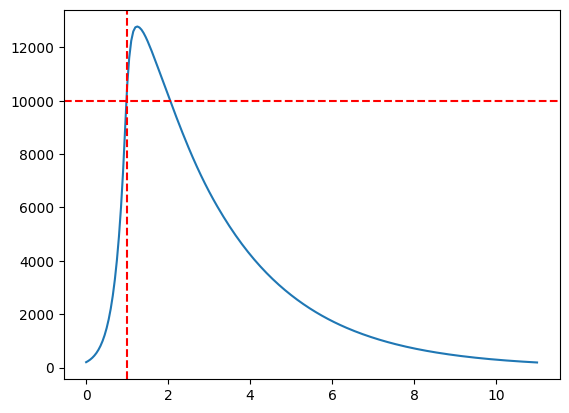

In [20]:
from scipy.integrate import solve_ivp
dydt = m_early_start.get_dydt(jit=True)

det_result = solve_ivp(dydt, t_span_early_start, m_early_start.make_initial_condition({'Y':y0_early_start}), t_eval=t_eval_early_start, args=(0,))
det_result = pd.Series(det_result.y.T.squeeze(), index=det_result.t)
det_result.name = 'deterministic'

ax = det_result.plot()
det_result.index = det_result.index.round(3)

ax.axvline(1.0, c='r', linestyle='--')
ax.axhline(10000, c='r', linestyle='--')

In [23]:
ic = m.make_initial_condition({'Y':det_result.loc[1.0]})

## Homogeneous

In [24]:
from hybrid.tau import TauLeapSimulator

tau_simulator = TauLeapSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    epsilon=epsilon,
    discontinuities=discontinuities
    #time_handling='inhomogeneous_monotonic'
)

In [130]:
results = tau_simulator.run_simulations(
    200,
    t_span,
    ic,
    np.random.default_rng(),
    t_eval=t_eval,
)

<Axes: >

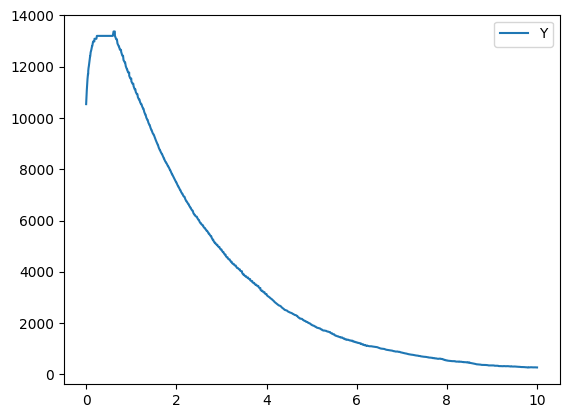

In [131]:
results[0].plot(m.legend())

In [136]:
tau_df = make_df(results, t_eval)
tau_df.index = tau_df.index.round(3)

In [137]:
cmap = {4:'gold', 2:'dodgerblue', 0: 'r', -2:'b', 1:'r'}

In [138]:
step_df_homo = pd.DataFrame({'t': results[0].step_t_history, 'status': results[0].status_history, 'y': results[0].step_y_history[0]})
step_df_homo['step size'] = step_df_homo['t'].diff()
step_df_homo['step amount'] = step_df_homo['y'].diff()
step_df_homo = step_df_homo.loc[1:]
step_df_homo['t'] += 1

<Axes: xlabel='t', ylabel='step size'>

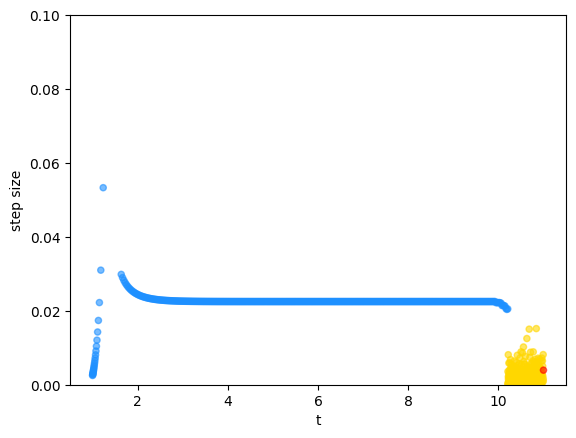

In [139]:
color = step_df_homo.status.map(cmap)
step_df_homo.plot.scatter(x='t', y='step size', c=color, ylim=[0.0, 0.1], alpha=0.6)

## Inbetween

In [140]:
from hybrid.tau import TauLeapSimulator

inhom_tau_simulator = TauLeapSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    epsilon=epsilon*2,
    time_handling='inhomogeneous_monotonic_homogeneous_gillespie',
    discontinuities=discontinuities,
)

In [141]:
ibresults = inhom_tau_simulator.run_simulations(
    100,
    t_span,
    ic,
    np.random.default_rng(1),
    t_eval=t_eval
)

Candidate inhomo time 0.0004556840650998366. Homo: 0.005
Candidate inhomo time 0.0004608721592041884. Homo: 0.0050632911619780075
Candidate inhomo time 0.00046612606885923513. Homo: 0.0051275477969920805
Candidate inhomo time 0.000471446784018947. Homo: 0.005192788846192169
Candidate inhomo time 0.00047683531314238355. Homo: 0.005259033734586741
Candidate inhomo time 0.0004822926836191275. Homo: 0.005326302386610391
Candidate inhomo time 0.0004878199422187285. Homo: 0.0053946152422965485
Candidate inhomo time 0.0004934181555433337. Homo: 0.005463993274084676
Candidate inhomo time 0.000499088410494368. Homo: 0.005534458004289827
Candidate inhomo time 0.000504831814759785. Homo: 0.005606031523265363
Candidate inhomo time 0.0005106494973088368. Homo: 0.005678736508292173
Candidate inhomo time 0.0005165426088997682. Homo: 0.005752596243227617
Candidate inhomo time 0.0005225123226116991. Homo: 0.00582763463894984
Candidate inhomo time 0.0005285598343771829. Homo: 0.005903876254636726
Candid

In [142]:
in_between_df = make_df(ibresults, t_eval)
in_between_df.index = in_between_df.index.round(3)

In [143]:
step_df_ib = pd.DataFrame({'t': ibresults[0].step_t_history, 'status': ibresults[0].status_history, 'y': ibresults[0].step_y_history[0]})
step_df_ib['step size'] = step_df_ib['t'].diff()
step_df_ib['step amount'] = step_df_ib['y'].diff()
step_df_ib = step_df_ib.loc[1:]
step_df_ib['t'] += 1

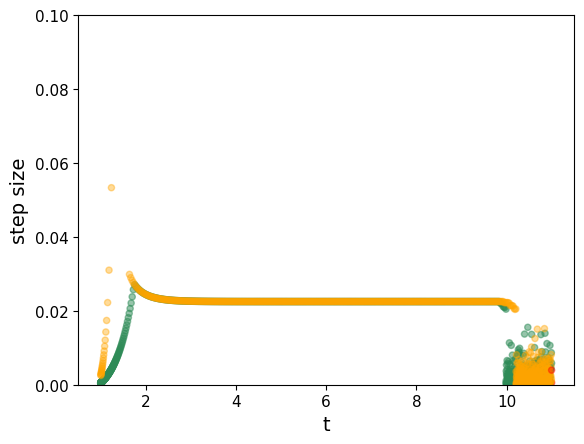

In [169]:
cmap = {4:'seagreen', 2:'seagreen', 0: 'r', -2:'b', 1:'r'}
ax = step_df_ib.plot.scatter(x='t', y='step size', c=step_df_ib.status.map(cmap), ylim=[0.0, 0.1], alpha=0.5)
cmap = {4:'orange', 2:'orange', 0: 'r', -2:'b', 1:'r'}
step_df_homo.plot.scatter(x='t', y='step size', c=step_df_homo.status.map(cmap), ylim=[0.0, 0.1], alpha=0.4, ax=ax)
plt.savefig('./inhomogeneous_stepsize.png', dpi=300)

### Single inbetween for study

In [ ]:
out_result = inhom_tau_simulator.simulate([0.0, 1.00], ic, np.random.default_rng(0), t_eval=t_eval)

In [ ]:
many_from_one = inhom_tau_simulator.run_simulations(50, [1.00, t_upper], out_result.y, np.random.default_rng(), t_eval=t_eval)

In [65]:
early_pause_df = make_df(many_from_one, t_eval)
early_pause_df.index = early_pause_df.index.round(3)

In [ ]:
np.array([r.y for r in many_from_one]).mean()

In [67]:
death = Reaction([Y], [], k=mu)
birth = Reaction([Y], [(Y, 2)], k=lambda_t_late_start)

m_late = Model([Y], [birth, death])

inhom_tau_simulator2 = TauLeapSimulator(
    m_late.get_k(jit=True),
    m_late.stoichiometry(),
    m_late.kinetic_order(),
    epsilon=epsilon,
    time_handling='inhomogeneous_monotonic_homogeneous_gillespie',
)

In [235]:
late_results = inhom_tau_simulator2.run_simulations(
    100,
    t_span_late_start,
    m_late.make_initial_condition({'Y':10000}),
    np.random.default_rng(),
    t_eval=t_eval
)

Candidate inhomo time 0.00022662515896282922. Homo: 0.0025
Candidate inhomo time 0.00022790754354230813. Homo: 0.0025157232777884616
Candidate inhomo time 0.00022919800215276927. Homo: 0.002531565471681578
Candidate inhomo time 0.00023049659492316044. Homo: 0.002547527734563941
Candidate inhomo time 0.0002318033825356374. Homo: 0.00256361123382246
Candidate inhomo time 0.00023311842623423285. Homo: 0.00257981715157524
Candidate inhomo time 0.00023444178783077458. Homo: 0.002596146684904995
Candidate inhomo time 0.00023577352971153732. Homo: 0.0026126010460968616
Candidate inhomo time 0.00023711371484361245. Homo: 0.0026291814628807957
Candidate inhomo time 0.0002384624067791866. Homo: 0.0026458891786786108
Candidate inhomo time 0.000239819669668296. Homo: 0.002662725452855598
Candidate inhomo time 0.0002411855682600484. Homo: 0.002679691560977432
Candidate inhomo time 0.00024256016791284894. Homo: 0.002696788795071682
Candidate inhomo time 0.0002439435345988232. Homo: 0.002714018463894

In [236]:
late_df = make_df(late_results, t_eval)
late_df.index = late_df.index.round(3) + 1

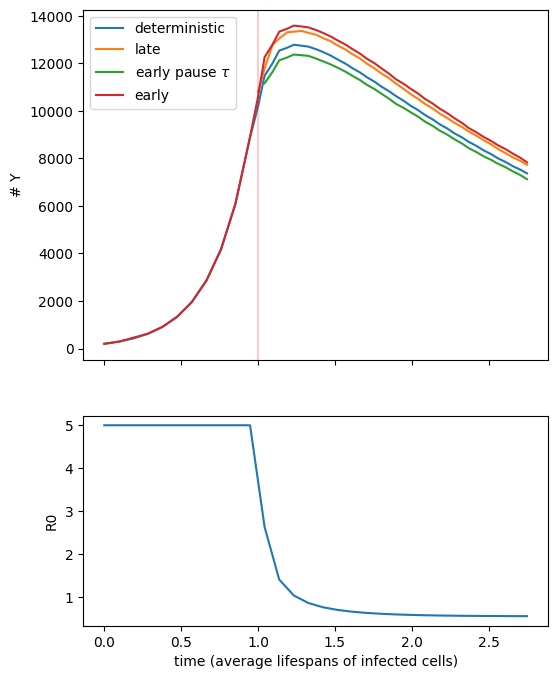

In [237]:
fig, ax = plt.subplots(2, height_ratios=[1.0, 0.6], figsize=(6,8), sharex=True)

data = {
    'deterministic': det_result,
    'late': late_df.mean(axis=1),
    'early pause $\\tau$': early_pause_df.mean(axis=1),
    'early': in_between_df.mean(axis=1),
}
combined = pd.DataFrame(data)
combined.interpolate(method='linear').plot(ax=ax[0])
#tau_df.mean(axis=1).plot(ax=ax)

ax[1].set_xlabel('time (average lifespans of infected cells)')
ax[0].set_ylabel('# Y')
ax[0].axvline(1.0, c='r', alpha=0.2)

R0s = [lambda_t(t)/mu for t in t_eval]

ax[1].plot(t_eval, R0s)
ax[1].set_ylabel('R0')

plt.savefig('./inhomogeneous.png', dpi=300)

In [238]:
combined

deterministic      late  early pause $\tau$     early
0.000     200.000000       NaN                 NaN    200.00
0.095     292.268616       NaN                 NaN    291.32
0.190     427.041429       NaN                 NaN       NaN
0.284     624.059053       NaN                 NaN    626.22
0.379     912.055262       NaN                 NaN    914.70
0.474    1332.219091       NaN                 NaN   1343.34
0.569    1946.945917       NaN                 NaN   1959.66
0.664    2845.894971       NaN                 NaN   2862.86
0.759    4157.237496       NaN                 NaN   4176.08
0.853    6072.876593       NaN                 NaN   6100.74
0.948    8878.152640       NaN                 NaN   8906.58
1.000            NaN  10800.00                 NaN       NaN
1.043   11481.914083       NaN            11160.64  12262.62
1.095            NaN  12779.80                 NaN       NaN
1.138   12534.209318       NaN            12126.16  13331.56
1.190            NaN  13306.07                 NaN       NaN
1.233   12781.091874       NaN            12369.66  13586.44
1.284            NaN  13362.56                 NaN       NaN
1.328   12703.052093       NaN            12312.64  13512.32
1.379            NaN  13200.38                 NaN       NaN
1.422   12479.596766       NaN            12086.26  13282.68
1.474            NaN  12928.20                 NaN       NaN
1.517   12167.300225       NaN            11818.38  12968.62
1.569            NaN  12581.11                 NaN       NaN
1.612   11807.023090       NaN            11482.28  12609.98
1.664            NaN  12201.85                 NaN       NaN
1.707   11421.138539       NaN            11101.66  12200.62
1.759            NaN  11780.99                 NaN       NaN
1.802   11024.596337       NaN            10725.52  11795.44
1.853            NaN  11372.12                 NaN       NaN
1.897   10623.676315       NaN            10296.82  11331.34
1.948            NaN  10922.83                 NaN       NaN
1.991   10223.245049       NaN             9949.94  10939.52
2.043            NaN  10498.94                 NaN       NaN
2.086    9827.403722       NaN             9550.62  10504.38
2.138            NaN  10089.23                 NaN       NaN
2.181    9439.488131       NaN             9172.62  10097.18
2.233            NaN   9690.58                 NaN       NaN
2.276    9062.068682       NaN             8813.40   9698.28
2.328            NaN   9315.71                 NaN       NaN
2.371    8696.950394       NaN             8430.58   9276.90
2.422            NaN   8949.66                 NaN       NaN
2.466    8345.172894       NaN             8094.56   8909.88
2.517            NaN   8590.59                 NaN       NaN
2.560    8007.010424       NaN             7778.84   8556.30
2.612            NaN   8214.81                 NaN       NaN
2.655    7681.971834       NaN             7467.78   8213.10
2.707            NaN   7893.14                 NaN       NaN
2.750    7368.800587   7728.73             7125.66   7834.74

### Run many inbetween

In [74]:
ibresults[0].status_counter

Counter({<TauStepStatus.leap: 2>: 571,
         <TauStepStatus.stochastic: 4>: 399,
         <TauStepStatus.rejected_for_gillespie: -2>: 4,
         <TauStepStatus.t_end: 0>: 1})

In [75]:
ibresults[0].status_counter

Counter({<TauStepStatus.leap: 2>: 571,
         <TauStepStatus.stochastic: 4>: 399,
         <TauStepStatus.rejected_for_gillespie: -2>: 4,
         <TauStepStatus.t_end: 0>: 1})

In [211]:
df[df['status'] == 2.0].head(100)['step amount'].sum()

909.0

In [202]:
pause_df = pd.DataFrame({'t': many_from_one[0].step_t_history, 'status': many_from_one[0].status_history, 'y': many_from_one[0].step_y_history[0]})
pause_df = pause_df[pause_df['t'] > 1.0]
pause_df['step size'] = pause_df['t'].diff()
pause_df['step amount'] = pause_df['y'].diff()

In [204]:
pause_df.head(50)

t  status        y  step size  step amount
1   1.000227     2.0  10011.0        NaN          NaN
2   1.000455     2.0  10019.0   0.000228          8.0
3   1.000684     2.0  10023.0   0.000229          4.0
4   1.000914     2.0  10028.0   0.000230          5.0
5   1.001146     2.0  10038.0   0.000232         10.0
6   1.001379     2.0  10047.0   0.000233          9.0
7   1.001614     2.0  10054.0   0.000234          7.0
8   1.001849     2.0  10066.0   0.000236         12.0
9   1.002086     2.0  10074.0   0.000237          8.0
10  1.002325     2.0  10084.0   0.000238         10.0
11  1.002565     2.0  10096.0   0.000240         12.0
12  1.002806     2.0  10105.0   0.000241          9.0
13  1.003049     2.0  10116.0   0.000243         11.0
14  1.003292     2.0  10127.0   0.000244         11.0
15  1.003538     2.0  10133.0   0.000245          6.0
16  1.003785     2.0  10143.0   0.000247         10.0
17  1.004033     2.0  10156.0   0.000248         13.0
18  1.004282     2.0  10164.0   0.000250          8.0
19  1.004533     2.0  10176.0   0.000251         12.0
20  1.004786     2.0  10184.0   0.000252          8.0
21  1.005040     2.0  10193.0   0.000254          9.0
22  1.005295     2.0  10200.0   0.000255          7.0
23  1.005552     2.0  10208.0   0.000257          8.0
24  1.005810     2.0  10218.0   0.000258         10.0
25  1.006070     2.0  10222.0   0.000260          4.0
26  1.006331     2.0  10224.0   0.000261          2.0
27  1.006594     2.0  10238.0   0.000263         14.0
28  1.006858     2.0  10246.0   0.000264          8.0
29  1.007124     2.0  10254.0   0.000266          8.0
30  1.007391     2.0  10262.0   0.000267          8.0
31  1.007660     2.0  10277.0   0.000269         15.0
32  1.007930     2.0  10282.0   0.000270          5.0
33  1.008202     2.0  10290.0   0.000272          8.0
34  1.008476     2.0  10298.0   0.000274          8.0
35  1.008751     2.0  10306.0   0.000275          8.0
36  1.009028     2.0  10318.0   0.000277         12.0
37  1.009306     2.0  10323.0   0.000278          5.0
38  1.009586     2.0  10337.0   0.000280         14.0
39  1.009868     2.0  10351.0   0.000282         14.0
40  1.010151     2.0  10358.0   0.000283          7.0
41  1.010436     2.0  10372.0   0.000285         14.0
42  1.010722     2.0  10378.0   0.000287          6.0
43  1.011011     2.0  10384.0   0.000288          6.0
44  1.011300     2.0  10388.0   0.000290          4.0
45  1.011592     2.0  10393.0   0.000292          5.0
46  1.011885     2.0  10403.0   0.000293         10.0
47  1.012180     2.0  10414.0   0.000295         11.0
48  1.012477     2.0  10417.0   0.000297          3.0
49  1.012775     2.0  10433.0   0.000298         16.0
50  1.013076     2.0  10444.0   0.000300         11.0

In [212]:
pause_df[pause_df['status'] == 2.0].head(100)['step amount'].sum()

850.0

<Axes: xlabel='t', ylabel='step size'>

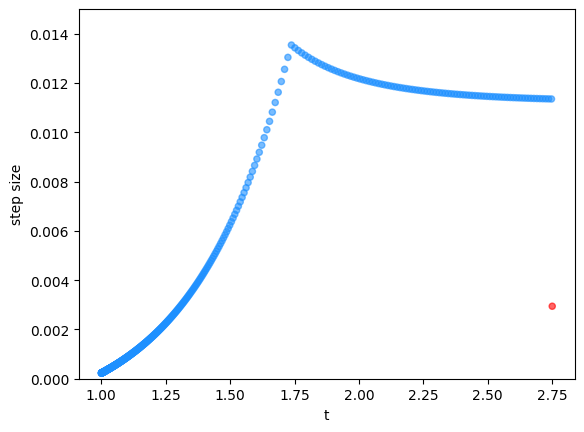

In [134]:
color = pause_df.status.map(map)
pause_df.plot.scatter(x='t', y='step size', c=color, ylim=[0.0, 0.015], alpha=0.6)

<Axes: >

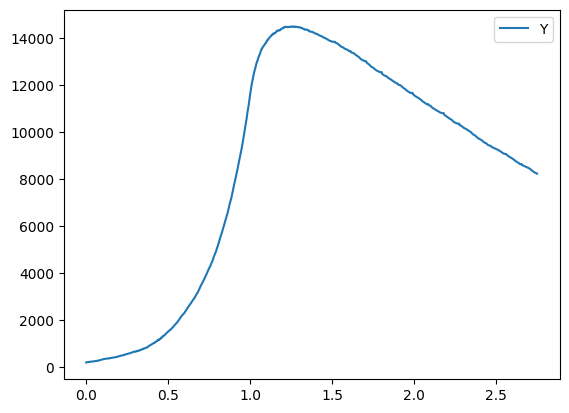

In [136]:
ibresults[1].plot(m.legend())

## Implicit

In [99]:
from hybrid.tau import TauLeapSimulator

implicit_tau_simulator = TauLeapSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    epsilon=epsilon,
    discontinuities=discontinuities,
    method='implicit'
)

In [101]:
impresults = implicit_tau_simulator.run_simulations(
    100,
    t_span,
    ic,
    np.random.default_rng(),
    t_eval=t_eval
)

In [102]:
implicit_df = make_df(impresults, t_eval)
implicit_df.index = implicit_df.index.round(3)

## Inhomogeneous

In [81]:
from hybrid.tau import TauLeapSimulator

inhom_tau_simulator = TauLeapSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    epsilon=epsilon,
    time_handling='inhomogeneous_monotonic',
    discontinuities=discontinuities,
)

In [35]:
results = inhom_tau_simulator.run_simulations(
    100,
    t_span,
    ic,
    np.random.default_rng(),
    t_eval=t_eval
)

Candidate inhomo time 0.00022662515896227682. Homo: 0.0025
Candidate inhomo time 0.00022790754354229574. Homo: 0.002515723277788426
Candidate inhomo time 0.00022919800215283508. Homo: 0.002531565471681539
Candidate inhomo time 0.00023049659492319793. Homo: 0.0025475277345639044
Candidate inhomo time 0.00023180338253566806. Homo: 0.0025636112338224258
Candidate inhomo time 0.0002331184262342822. Homo: 0.0025798171515752123
Candidate inhomo time 0.00023444178783136403. Homo: 0.00259614668490497
Candidate inhomo time 0.00023577352971193406. Homo: 0.002612601046096876
Candidate inhomo time 0.00023711371484310336. Homo: 0.0026291814628808382
Candidate inhomo time 0.00023846240677915257. Homo: 0.002645889178678616
Candidate inhomo time 0.00023981966966868878. Homo: 0.0026627254528556
Candidate inhomo time 0.00024118556826057023. Homo: 0.002679691560977464
Candidate inhomo time 0.00024256016791231785. Homo: 0.002696788795071751
Candidate inhomo time 0.00024394353459822424. Homo: 0.00271401846

KeyboardInterrupt: 

In [ ]:
results[0].plot(m.legend())

In [58]:
inhomo_df = make_df(results, t_eval)
inhomo_df.index = inhomo_df.index.round(3)

In [ ]:
results[0].status_counter

## Results

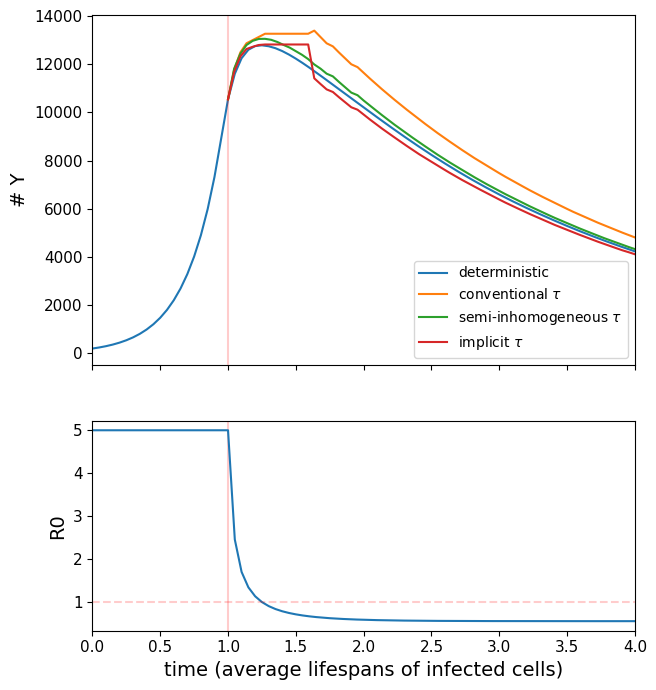

In [167]:
fig, ax = plt.subplots(2, height_ratios=[1.0, 0.6], figsize=(7,8), sharex=True)

data = {
    #'gillespie': gillespie_df.mean(axis=1),
    'conventional $\\tau$': tau_df.mean(axis=1),
    #'inhomogeneous $\\tau$': inhomo_df.mean(axis=1),
    'semi-inhomogeneous $\\tau$': in_between_df.mean(axis=1),
    'implicit $\\tau$': implicit_df.mean(axis=1),
}
combined = pd.DataFrame(data)
combined.index = combined.index + 1
combined = pd.merge(det_result, combined, left_index=True, right_index=True, how='outer')

for column in combined.columns:
    combined[column].dropna().plot(ax=ax[0])

ax[0].legend(combined.columns)

ax[1].set_xlabel('time (average lifespans of infected cells)')
ax[0].set_ylabel('# Y')
ax[0].axvline(1.0, c='r', alpha=0.2)
ax[1].axvline(1.0, c='r', alpha=0.2)


R0s = [lambda_t_early_start(t)/mu for t in t_eval_early_start]

ax[1].plot(t_eval_early_start, R0s)
ax[1].set_ylabel('R0')
ax[1].axhline(1.0, c='r', linestyle='--', alpha=0.2)

ax[1].set_xlim([0.0, 4.0])

plt.savefig('./inhomogeneous.png', dpi=300)

In [119]:
from scipy.integrate import simpson

In [120]:
combined.columns

Index(['deterministic', 'conventional $\tau$', 'semi-inhomogeneous $\tau$',
       'implicit $\tau$'],
      dtype='object')

In [121]:
deterministic = combined['deterministic'].dropna()
#deterministic = deterministic[deterministic.index >= 1.0]
det_AUC = simpson(y=deterministic, x=deterministic.index)

In [122]:
det_nub = combined['deterministic'].dropna()
det_nub = det_nub[det_nub.index <= 1.0]
nub_AUC = simpson(y=det_nub, x=det_nub.index)

In [123]:
conventional = combined['conventional $\\tau$'].dropna()
conventional_AUC = simpson(y=conventional, x=conventional.index) + nub_AUC

In [124]:
semi = combined['semi-inhomogeneous $\\tau$'].dropna()
semi_AUC = simpson(y=semi, x=semi.index) + nub_AUC

In [125]:
implicit = combined['implicit $\\tau$'].dropna()
implicit_AUC = simpson(y=implicit, x=implicit.index) + nub_AUC

In [126]:
implicit_AUC

36622.14608498981

In [127]:
(det_AUC - conventional_AUC)/det_AUC

-0.10701525333317075

In [128]:
(det_AUC - semi_AUC)/det_AUC

-0.02009882036114045

In [129]:
(det_AUC - implicit_AUC)/det_AUC

0.015702314471842973